In [1]:
# try:
#   %load_ext autotime
# except:
#   print("Console warning-- Autotime is jupyter platform specific")

## Notebook synopsis
This Notebook takes tabular data and location of image files, checks distribution of classes, and applies weights to each class to be trained. In addition it tries to take takes as close to an equal distribution of a test data set to properly match test results through all classes. During analysis it notifies and suggests of any skewness of a dataset and suggests different ways of handling the dataset. Lastly a custom split function is written to split data according to parameters and prepare datasets for training, testing and validation. 

#### Skills
- Dataset import
- Dataframe manipulation and analysis
- Custom function creation 

In [2]:
from comet_ml import Experiment
import math
from pyforest import *
lazy_imports()
from pydicom import dcmread

<IPython.core.display.Javascript object>

In [3]:
df = pd.read_csv('/media/gyasis/Drive 2/Data/vinbigdata/train.csv')
df.head(10)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
5,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,R9,627.0,357.0,947.0,433.0
6,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,R17,1347.0,245.0,2188.0,2169.0
7,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,R9,557.0,2352.0,675.0,2484.0
8,d3637a1935a905b3c326af31389cb846,Aortic enlargement,0,R10,1329.0,743.0,1521.0,958.0
9,afb6230703512afc370f236e8fe98806,Pulmonary fibrosis,13,R9,1857.0,1607.0,2126.0,2036.0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='class_name', ylabel='Count'>

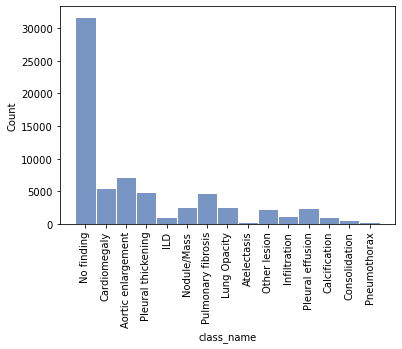

<IPython.core.display.Javascript object>

In [4]:
import seaborn as sns
plt.xticks(rotation=90)
sns.set_theme(style="dark")
sns.histplot(x=df.class_name, data=df)

In [5]:
df=df[['class_name','class_id','image_id']]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [6]:
def build_path(x):
    path_ = '/media/gyasis/Drive 2/Data/vinbigdata/train/'
    filetype = '.dicom'
    x = (path_+x+filetype)
    return x

df['imagepath'] = df['image_id'].apply(lambda x: build_path(x))
df=df[['class_name', 'class_id','imagepath']]
df.head()

<IPython.core.display.Javascript object>

,class_name,class_id,imagepath
0,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/50...
1,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/21...
2,Cardiomegaly,3,/media/gyasis/Drive 2/Data/vinbigdata/train/9a...
3,Aortic enlargement,0,/media/gyasis/Drive 2/Data/vinbigdata/train/05...
4,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/06...


<IPython.core.display.Javascript object>

In [7]:
pd.get_dummies(df['class_name'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,No finding,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67909,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
67910,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
67911,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
67912,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

In [8]:
df1 = pd.get_dummies(df['class_id'].astype(str))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#mapping for later use
disease= ["Aortic enlargement"
,"Atelectasis"
,"Calcification"
,"Cardiomegaly"
,"Consolidation"
,"ILD"
,"Infiltration"
,"Lung Opacity"
,"Nodule/Mass"
,"Other lesion"
,"Pleural effusion"
,"Pleural thickening"
,"Pneumothorax"
,"Pulmonary fibrosis"
,"No_finding"]

#map df.class_id to disease
# df['class_id_test'] = df['class_id'].map(lambda x: disease[x])
df.head()
df1.columns = df1.columns.astype("int").map(lambda x: disease[x])
sample_array = np.array(df1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
def get_class_frequencies():
  positive_freq = sample_array.sum(axis=0) / sample_array.shape[0]
  negative_freq = np.ones(positive_freq.shape) - positive_freq
  return positive_freq, negative_freq

p,n = get_class_frequencies()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

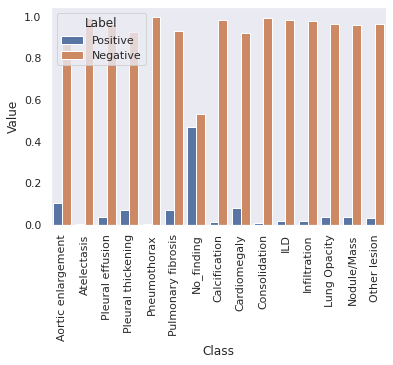

<IPython.core.display.Javascript object>

In [11]:
data = pd.DataFrame({"Class": df1.columns, "Label": "Positive", "Value": p})
data = data.append([{"Class": df1.columns[l], "Label": "Negative", "Value": v} for l, v in enumerate(n)], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value",hue="Label", data=data)

In [12]:
pos_weights = n
neg_weights = p
pos_contribution = p * pos_weights
neg_contribution = n * neg_weights
print(p)
print(n)

print("Weight to be added:  ",pos_contribution)

<IPython.core.display.Javascript object>

[0.1054569  0.00410814 0.03645787 0.07129605 0.00332774 0.06854257
 0.46850428 0.01413552 0.07990989 0.00818682 0.0147245  0.01836146
 0.03656094 0.03798922 0.03243808]
[0.8945431  0.99589186 0.96354213 0.92870395 0.99667226 0.93145743
 0.53149572 0.98586448 0.92009011 0.99181318 0.9852755  0.98163854
 0.96343906 0.96201078 0.96756192]
Weight to be added:   [0.09433574 0.00409126 0.0351287  0.06621292 0.00331666 0.06384448
 0.24900802 0.01393571 0.0735243  0.0081198  0.01450769 0.01802431
 0.03522424 0.03654604 0.03138585]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

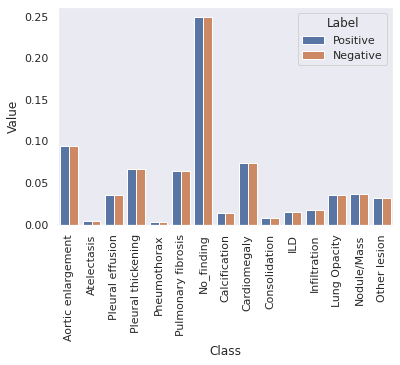

<IPython.core.display.Javascript object>

In [13]:
data = pd.DataFrame({"Class": df1.columns, "Label": "Positive", "Value": pos_contribution})
data = data.append([{"Class": df1.columns[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)], ignore_index=True)
plt.xticks(rotation=90)
g = sns.barplot(x="Class", y="Value",hue="Label", data=data)

In [14]:
from sklearn.model_selection import train_test_split

X, y = df.imagepath, df.class_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
print(f"Numbers of train instances by class: {np.bincount(y_train)}")
print(f"Numbers of test instances by class: {np.bincount(y_test)}")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Numbers of train instances by class: [ 5805   223   764  4361   453   805  1003  2006  2026  1763  1963  3918
   180  3704 25357]


<IPython.core.display.Javascript object>

Numbers of test instances by class: [1357   56  196 1066  103  195  244  477  554  440  513  924   46  951
 6461]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Train set')

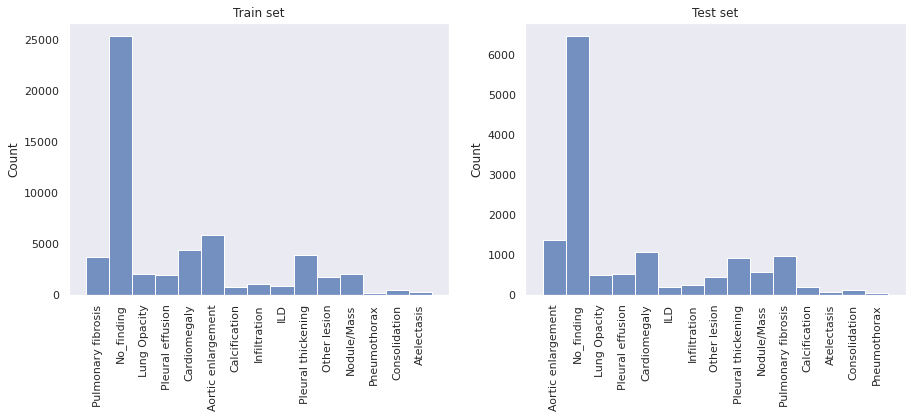

<IPython.core.display.Javascript object>

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
g1 = sns.histplot(x=(list(map(lambda y_train: disease[y_train], y_train))), ax=ax1 )
g2= sns.histplot(x=(list(map(lambda y_test: disease[y_test], y_test))), ax=ax2, )
g2.set_title("Test set")
g1.set_title("Train set")

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
print(len(df))

<IPython.core.display.Javascript object>

67914


<IPython.core.display.Javascript object>

In [19]:
print(len(df)/len(df.class_id.unique()))

<IPython.core.display.Javascript object>

4527.6


<IPython.core.display.Javascript object>

In [20]:
proposed_split = (len(df)*0.20)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
proposed_split / len(df.class_id.unique())

<IPython.core.display.Javascript object>

905.5200000000001

<IPython.core.display.Javascript object>

In [22]:
print(len(df.class_id.unique()))

<IPython.core.display.Javascript object>

15


<IPython.core.display.Javascript object>

In [23]:
def prepare_class_split(dataframe, target="class_name", p_split=0.30, test_target_split=0.50, verbose=False, helpers="dataframe"):
  dataframe = dataframe.copy()
  df_len = len(dataframe)
  class_amount = len(dataframe[target].unique())
  df_split = int(df_len * p_split)
  class_list = list(dataframe[target].unique())
  
  proposed_split = df_split/class_amount
  
  class_counts = dataframe[target].value_counts()
  # print(df_len,df_split,proposed_split,class_counts)
  
  outcomes = []
  total = []
  
  print("Total of Test Split is {} and Proposed split is {}".format(df_split,proposed_split))
  
  
  for lable in class_list:
    print('-----------------------------------------------------' + '\n')
    percent_split = class_counts[lable] / df_len
    proposed_percent_split = class_counts[lable] / df_split
    total.append(class_counts[lable])
    if class_counts[lable] >= proposed_split * 2:
      if verbose == True:
        print(f"Class {lable} has {class_counts[lable]} instances, which is greater than the proposed split of {proposed_split}")
        print(f"Class {lable} has {percent_split} of the total data, which is greater than the proposed split of {proposed_percent_split}")
        print("Class {} is OK!!".format(lable))
      outcomes.append("OK!!")
       
      
    elif class_counts[lable] < proposed_split * 2 and class_counts[lable] > proposed_split:
      if verbose == True:
        print("Class {} fails equity threshold, look to augment training dataset ".format(lable))
      outcomes.append("Augment??")
    elif class_counts[lable] < proposed_split:
      if verbose == True:
        print("Class {} fails equity threshold, look to remove training dataset ".format(lable))
        print("Class {} is {} and Proposed split is {}".format(lable,class_counts[lable],proposed_split))
        print("Class " + lable + " is less than the proposed split")
        print("Class {} is {} and the proposed split is {}".format(lable,class_counts[lable],proposed_split))
        print("Both augmentation and weights may be necessary!!")
      outcomes.append("Weights/Augment/Split!!")
    print('-----------------------------------------------------' + '\n'+'\n')
  outcomes_df = pd.DataFrame()
  outcomes_df["Class"] = class_list
  outcomes_df["Split"] = math.floor(proposed_split)
  outcomes_df["Set_Number"] = total
  outcomes_df["Outcome"] = outcomes
  outcomes_df.set_index("Class", inplace=True)
  
  
  # Change dataframe based on outcomes
  for i, out in enumerate(outcomes_df.Outcome):
    print(i)

    if out == "Augment??":
      outcomes_df.iat[i,0] = outcomes_df.Split[i] * 0.80
      # print(outcomes_df.iat[i,1])
    elif out == "Weights/Augment/Split!!":
      outcomes_df.iat[i, 0] = math.floor(outcomes_df.Set_Number[i]*0.50)
      # outcomes_df = outcomes_df.append(outcomes_df.at[i,"Set Number"] == math.floor(temp/0.5))
      # dataframe = dataframe.append(dataframe.loc[dataframe[target] == i])
    elif out == "OK!!":
      pass
    else:
      print("Error")
  
  
  if helpers == "dataframe":
    return outcomes_df

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
test = prepare_class_split(df, target="class_name", p_split=0.20, test_target_split=0.50, verbose=True, helpers="dataframe")
df['class'] = df['class_id'].apply(lambda x:disease[x])

<IPython.core.display.Javascript object>

Total of Test Split is 13582 and Proposed split is 905.4666666666667
-----------------------------------------------------

Class No finding has 31818 instances, which is greater than the proposed split of 905.4666666666667
Class No finding has 0.46850428483081547 of the total data, which is greater than the proposed split of 2.3426594021499043
Class No finding is OK!!
-----------------------------------------------------


-----------------------------------------------------

Class Cardiomegaly has 5427 instances, which is greater than the proposed split of 905.4666666666667
Class Cardiomegaly has 0.07990988603233501 of the total data, which is greater than the proposed split of 0.3995729642173465
Class Cardiomegaly is OK!!
-----------------------------------------------------


-----------------------------------------------------

Class Aortic enlargement has 7162 instances, which is greater than the proposed split of 905.4666666666667
Class Aortic enlargement has 0.105456901375268

<IPython.core.display.Javascript object>

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


<IPython.core.display.Javascript object>

In [25]:
def custom_split(dataframe1,dataframe2):
  dataframe2 = dataframe2.copy(deep=True)
  dataframe3 = dataframe2.copy(deep=True)
  dataframe2 = dataframe2.sample(frac=1)
  
  
  test_idx = []
  temp = list(dataframe1.index)
  print(temp)
  for i, class_ in enumerate(temp):
    total = dataframe1.iat[i, 0]
    print(total)
    for index, row in dataframe2.iterrows():
      if row["class_name"] == class_ and total > 0 :
        total -= 1
        test_idx.append(index)
        dataframe2.drop(index, inplace=True)
        
        # print("drop")
    print("Finished ", class_)
    
  print(len(dataframe2))
  
  dataframe3 = dataframe3.loc[dataframe3.index[test_idx]]
  dataframe2 = dataframe2.sample(frac=1)
  dataframe3 = dataframe3.sample(frac=1)
  print(len(dataframe3))
  return dataframe2, dataframe3

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
train_df, test_df= custom_split(test, df)

<IPython.core.display.Javascript object>

['No finding', 'Cardiomegaly', 'Aortic enlargement', 'Pleural thickening', 'ILD', 'Nodule/Mass', 'Pulmonary fibrosis', 'Lung Opacity', 'Atelectasis', 'Other lesion', 'Infiltration', 'Pleural effusion', 'Calcification', 'Consolidation', 'Pneumothorax']
905
Finished  No finding
905
Finished  Cardiomegaly
905
Finished  Aortic enlargement
905
Finished  Pleural thickening
724
Finished  ILD
905
Finished  Nodule/Mass
905
Finished  Pulmonary fibrosis
905
Finished  Lung Opacity
139
Finished  Atelectasis
905
Finished  Other lesion
724
Finished  Infiltration
905
Finished  Pleural effusion
724
Finished  Calcification
278
Finished  Consolidation
113
Finished  Pneumothorax
57067
10847


<IPython.core.display.Javascript object>

In [27]:
train_df.head()

<IPython.core.display.Javascript object>

,class_name,class_id,imagepath,class
25473,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/70...,No_finding
38910,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/46...,No_finding
34413,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/63...,No_finding
61409,Pleural effusion,10,/media/gyasis/Drive 2/Data/vinbigdata/train/bf...,Pleural effusion
52312,Infiltration,6,/media/gyasis/Drive 2/Data/vinbigdata/train/d9...,Infiltration


<IPython.core.display.Javascript object>

In [28]:
train_df["class_name"].value_counts()

<IPython.core.display.Javascript object>

No finding            30913
Aortic enlargement     6257
Cardiomegaly           4522
Pleural thickening     3937
Pulmonary fibrosis     3750
Nodule/Mass            1675
Lung Opacity           1578
Pleural effusion       1571
Other lesion           1298
Infiltration            523
Consolidation           278
ILD                     276
Calcification           236
Atelectasis             140
Pneumothorax            113
Name: class_name, dtype: int64

<IPython.core.display.Javascript object>

In [29]:
test_df.head()

<IPython.core.display.Javascript object>

,class_name,class_id,imagepath,class
29261,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/03...,No_finding
18245,Other lesion,9,/media/gyasis/Drive 2/Data/vinbigdata/train/da...,Other lesion
64472,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/63...,No_finding
22349,No finding,14,/media/gyasis/Drive 2/Data/vinbigdata/train/72...,No_finding
7595,Pulmonary fibrosis,13,/media/gyasis/Drive 2/Data/vinbigdata/train/1a...,Pulmonary fibrosis


<IPython.core.display.Javascript object>

In [30]:
test_df["class_name"].value_counts()

<IPython.core.display.Javascript object>

Pleural effusion      905
No finding            905
Aortic enlargement    905
Other lesion          905
Pleural thickening    905
Cardiomegaly          905
Pulmonary fibrosis    905
Nodule/Mass           905
Lung Opacity          905
Infiltration          724
ILD                   724
Calcification         724
Consolidation         278
Atelectasis           139
Pneumothorax          113
Name: class_name, dtype: int64

<IPython.core.display.Javascript object>

In [31]:
train_dummies = pd.get_dummies(train_df.class_name)
test_dummies = pd.get_dummies(test_df.class_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
train_dummies.head(20)

<IPython.core.display.Javascript object>

,Aortic enlargement,Atelectasis,Calcification,Cardiomegaly,Consolidation,ILD,Infiltration,Lung Opacity,No finding,Nodule/Mass,Other lesion,Pleural effusion,Pleural thickening,Pneumothorax,Pulmonary fibrosis
25473,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
38910,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
34413,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
61409,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
52312,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
45451,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7601,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4057,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
54490,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
7857,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0.5, 1.0, 'Train set')

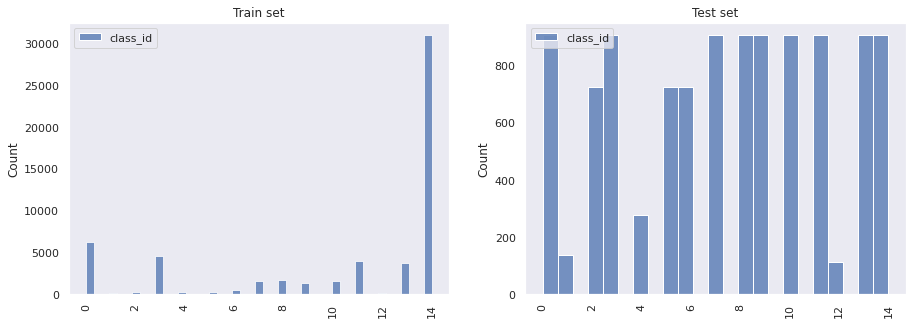

<IPython.core.display.Javascript object>

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.tick_params(axis='x', labelrotation=90)
ax2.tick_params(axis='x', labelrotation=90)
g1 = sns.histplot(train_df, ax=ax1)
g2= sns.histplot(test_df, ax=ax2)
g2.set_title("Test set")
g1.set_title("Train set")
# g1.set_xticklabels(disease)

In [34]:
def get_class_frequencies(dataframe,target):
  try:
    dataframe = pd.get_dummies(dataframe[target].astype(str))
  except:
    dataframe = pd.get_dummies(dataframe[target])
    
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  sample_array = np.array(dataframe)
  positive_freq = sample_array.sum(axis=0) / sample_array.shape[0]
  negative_freq = np.ones(positive_freq.shape) - positive_freq
  data = pd.DataFrame({"Class": dataframe.columns, "Label": "Positive", "Value": positive_freq})
  data = data.append([{"Class": dataframe.columns[l], "Label": "Negative", "Value": v} for l, v in enumerate(negative_freq)], ignore_index=True)
  plt.xticks(rotation=90)
  sns.barplot(x="Class", y="Value",hue="Label", data=data, ax=ax1)
  pos_weights = negative_freq
  neg_weights = positive_freq
  pos_contribution = positive_freq * pos_weights
  neg_contribution = negative_freq * neg_weights

  # print("Weight to be added:  ",pos_contribution)
  
  data1 = pd.DataFrame({"Class": dataframe.columns, "Label": "Positive", "Value": pos_contribution})
  data1 = data1.append([{"Class": dataframe.columns[l], "Label": "Negative", "Value": v} for l, v in enumerate(neg_contribution)], ignore_index=True)
  ax1.tick_params(axis='x', labelrotation=90)
  ax2.tick_params(axis='x', labelrotation=90)
  sns.barplot(x="Class", y="Value",hue="Label", data=data1, ax=ax2)
  
  return pos_contribution

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

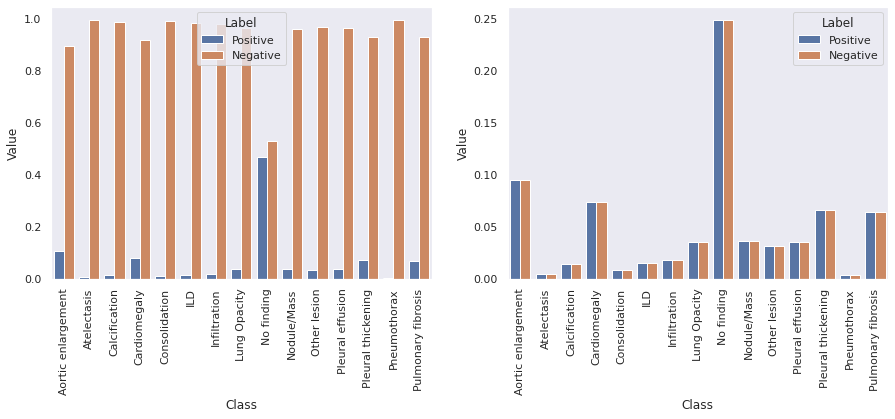

<IPython.core.display.Javascript object>

In [35]:
weights = get_class_frequencies(df, "class_name")

In [36]:
X, y = test_df.imagepath, test_df.class_id
X_valid, X_test, y_valid, y_test = train_test_split(X, y, test_size=0.5, random_state=42, stratify=y)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
valid = pd.concat([X_valid, y_valid], axis=1, join='inner')
#reset index 
valid = valid.reset_index(drop=True)
test = pd.concat([X_test, y_test], axis=1, join='inner')
test = test.reset_index(drop=True)
train = train_df[['imagepath', 'class_id']]
train = train.reset_index(drop=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>